In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
pd.set_option('future.no_silent_downcasting', True)

## **Data reading**

In [287]:
df_train = pd.read_csv('ressources/datasets/train_loans.csv')
display(df_train.head())

df_test = pd.read_csv('ressources/datasets/test_loans.csv')
display(df_test.head())

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [288]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [289]:
df_train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [290]:
nb_row = df_train.isnull().any(axis=1).sum()
print(f"There is {nb_row} rows with at least one missing value")

There is 134 rows with at least one missing value


Some values are missing in the training dataset, specially for the credit history

In [291]:
df_test.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

## **Data visualization**

### Predictor variables distribution

Credit_History
1.0    475
0.0     89
NaN     50
Name: count, dtype: int64


475 persons have already a credit
89 persons don't have any credit yet
For 50 persons its not specified in the dataset


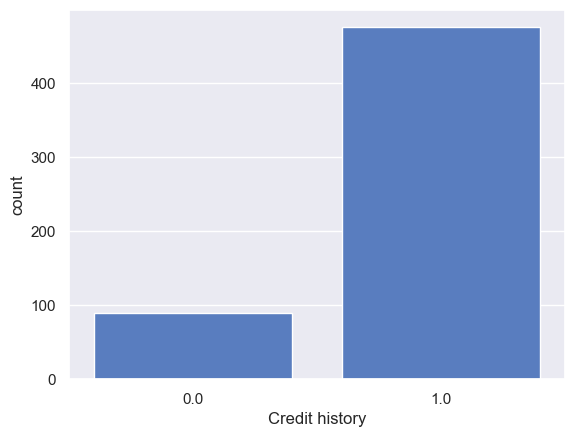

In [292]:
creditHistory = df_train['Credit_History'].value_counts(dropna=False)

sns.countplot(x=df_train['Credit_History'])
plt.xlabel('Credit history')

print(creditHistory)
print(f"\n\n{creditHistory[1.0]} persons have already a credit\n{creditHistory[0.0]} persons don't have any credit yet")
print(f"For {creditHistory.values[2]} persons its not specified in the dataset")

- There is a majority of person with existing credit amount the people asking for a loan

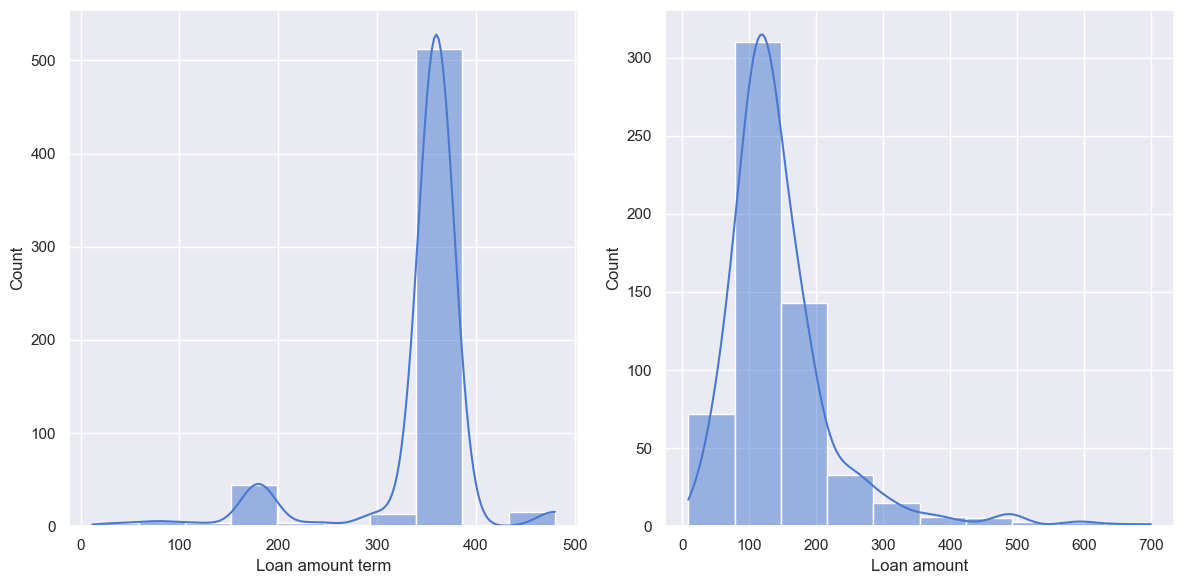

In [293]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.histplot(df_train['Loan_Amount_Term'], kde=True, bins=10)
plt.xlabel('Loan amount term')

plt.subplot(1, 2, 2)
sns.histplot(df_train['LoanAmount'], kde=True, bins=10)
plt.xlabel('Loan amount')

plt.tight_layout()
plt.show()

In [294]:
loan_amount_mean = round(df_train['LoanAmount'].mean(), 2)
loan_amountTerm_mean = df_train['Loan_Amount_Term'].mean()
print(f'mean Loan amount value : {loan_amount_mean}; mean Loan amount term : {loan_amountTerm_mean}')

mean Loan amount value : 146.41; mean Loan amount term : 342.0


- we can notice asymetrical distribution for numerical variables.
    - Negative asymmetry for the Loan amount term, most of the datas after the mean value
    - Positive asymmetry for the Loan amount, most of the datas before the mean value
- Important density of Loan amount term around **360**
- Important density of Loan amount around **130** (x $10^3$ **$** ?)

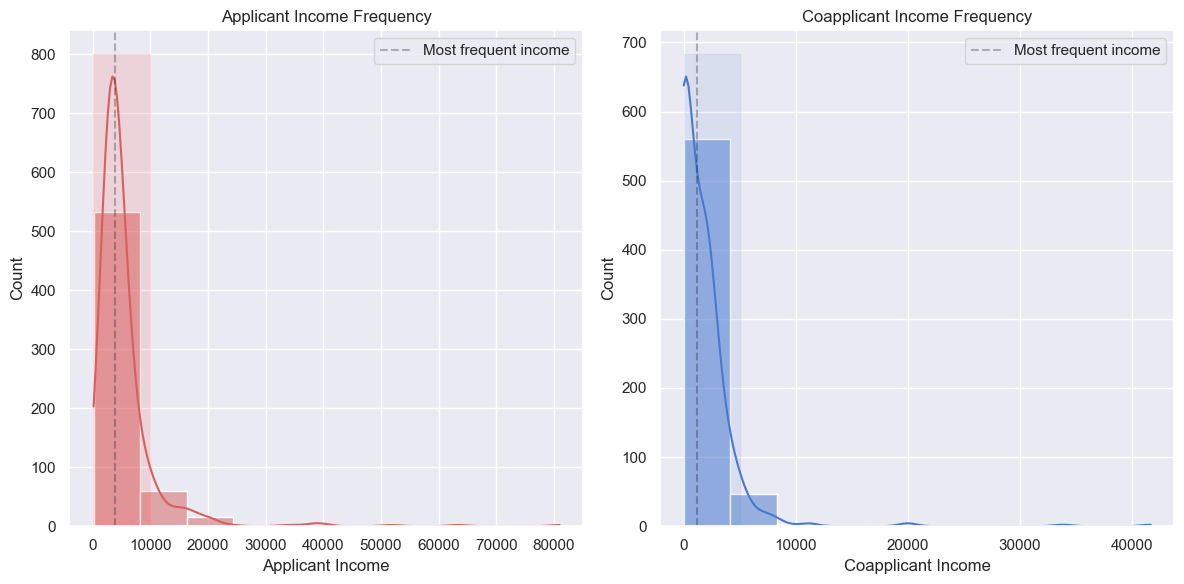

In [295]:
plt.figure(figsize=(12, 6))

# Applicant Income frequency visualisation
plt.subplot(1, 2, 1)
sns.histplot(df_train['ApplicantIncome'], bins=10, kde=True, color='r')
plt.axvline(df_train['ApplicantIncome'].median(), 
    color='k', 
    linestyle='--', 
    label='Most frequent income', 
    alpha=0.3)
plt.fill_betweenx([0, plt.ylim()[1]], 0, 10000, color='red', alpha=0.1)
plt.xlabel('Applicant Income')
plt.title('Applicant Income Frequency')
plt.legend()

# Coapplication Income frequenct visualisation
plt.subplot(1, 2, 2)
sns.histplot(df_train['CoapplicantIncome'], bins=10, kde=True, color='b')
plt.axvline(df_train['CoapplicantIncome'].median(), 
    color='k', linestyle='--', 
    label='Most frequent income', 
    alpha=0.3)
plt.fill_betweenx([0, plt.ylim()[1]], 0, 5000, color='b', alpha=0.1)
plt.xlabel('Coapplicant Income')
plt.title('Coapplicant Income Frequency')
plt.legend()

plt.tight_layout()
plt.show()

- The asymmetry of the applicants income show a trend around **3812**
- The asymetry of the coapplicants income show a trend arount **1188.5**

Text(0.5, 1.0, 'Gender frenquency')

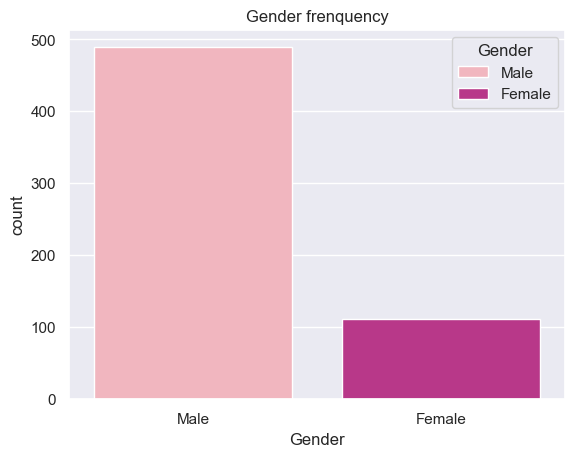

In [296]:
sns.countplot(x=df_train['Gender'], hue=df_train['Gender'], palette='RdPu')
plt.title('Gender frenquency')

There is more men thant woman among the loan applicants

<Axes: xlabel='Married', ylabel='count'>

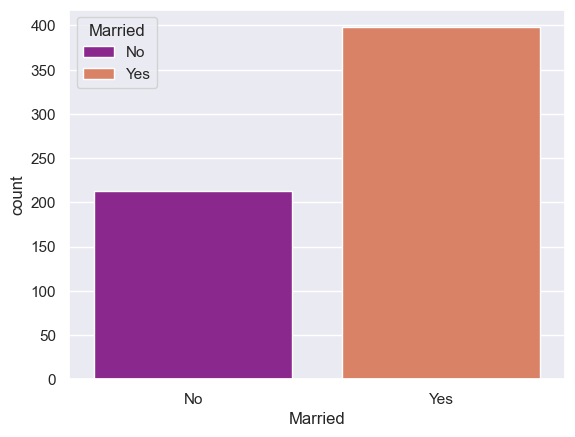

In [297]:
sns.countplot(x=df_train['Married'], hue=df_train['Married'], palette='plasma')

There is a majority of married people among the applicants

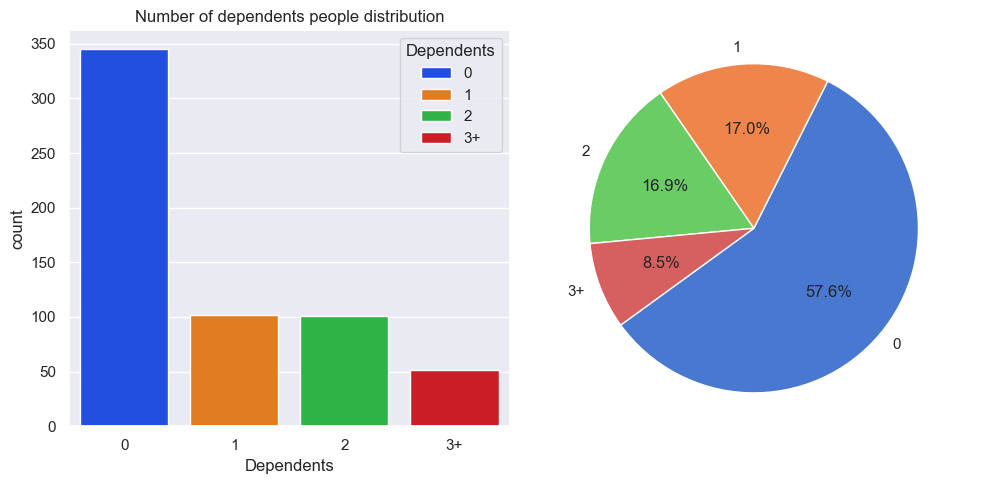

In [298]:
loan_dependents = df_train['Dependents'].value_counts(dropna=True)
plt.figure(figsize=(10, 5)) # figure in inches

plt.subplot(1, 2, 1)
sns.countplot(x=df_train['Dependents'], hue=df_train['Dependents'], palette='bright')
plt.title('Number of dependents people distribution')

# labels by descending order
plt.subplot(1, 2, 2)
plt.pie(loan_dependents, 
        labels=loan_dependents.keys(), 
        startangle=216, 
        autopct='%1.1f%%', 
        colors=sns.color_palette("muted", 
        len(loan_dependents)))

plt.axis('equal')  # Used to set the aspect ratio of the plot to be equal.

plt.tight_layout()
plt.show()

- Most of the applicants don't have any dependents person --> **58.6%**
- A minority of the applicants have 3 or more dependents persons --> **8.3%**

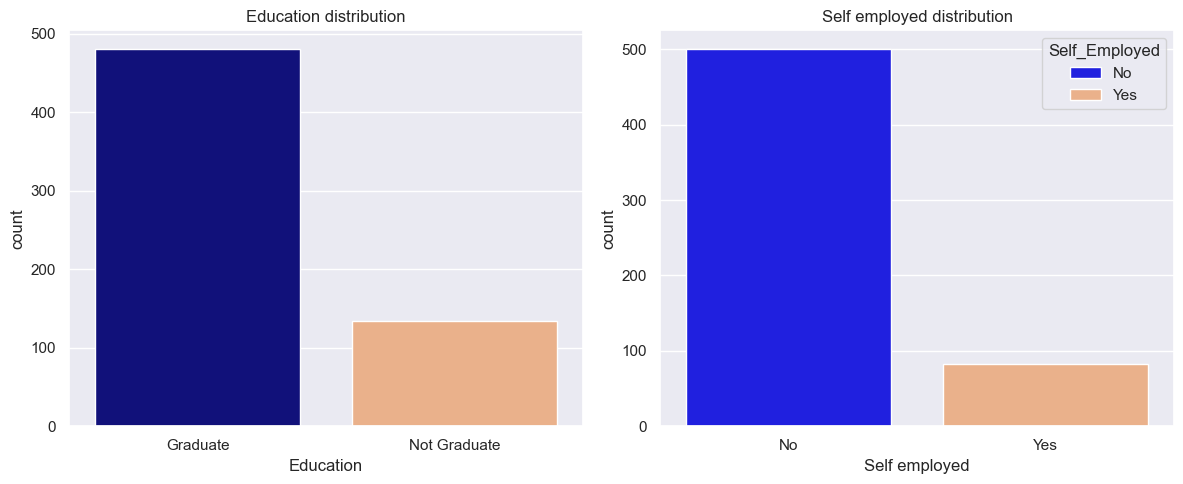

480 graduates people asking for a loan
82 peoples are self employed and 500 are not


In [299]:
self_employed_loan = df_train['Self_Employed'].value_counts(dropna=True)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=df_train['Education'], hue=df_train['Education'], palette=['darkblue',"#FAAE7B"])
plt.title("Education distribution")

plt.subplot(1, 2, 2)
sns.countplot(x=df_train['Self_Employed'], hue=df_train['Self_Employed'],palette=['blue',"#FAAE7B"])
plt.xlabel('Self employed')
plt.title('Self employed distribution')

plt.tight_layout()

plt.show()

graduate = df_train['Education'].loc[df_train['Education'] == 'Graduate']

print(f"{len(graduate)} graduates people asking for a loan")
print(f"{self_employed_loan['Yes']} peoples are self employed and {self_employed_loan['No']} are not")

- We can notice among the distribution of the people accorting to their education and employment :
    * A majority of **480** persons are graduate and just more than **100** are not
    * Most of the peoples asking for a loan are not self employed : around **500**
     and **82** are self employed

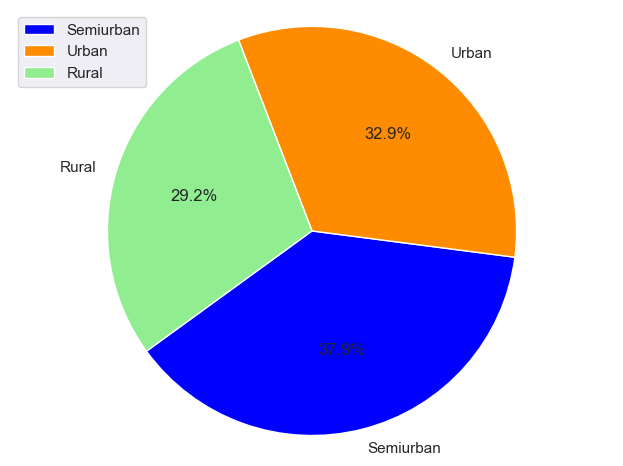

Semiurban: 233 peoples
Rural: 179 peoples
Semiurban: 233 peoples


In [300]:
property_loan = df_train['Property_Area'].value_counts(dropna=True)

plt.pie(property_loan, 
        labels=property_loan.keys(), 
        startangle=216, 
        autopct='%1.1f%%', 
        colors=sns.color_palette(['blue', 'darkorange', 'lightgreen'], 
        len(property_loan)))
plt.legend()
plt.axis('equal')  # Used to set the aspect ratio of the plot to be equal.

plt.tight_layout()
plt.show()

print(f"Semiurban: {property_loan['Semiurban']} peoples\nRural: {property_loan['Rural']} peoples\nSemiurban: {property_loan['Semiurban']} peoples")

- Most of the people asking for a loan live in a semiurban property area, **37.9%** for *233* peoples
- **32.9%** of the registered peoples live in a urban property, *233* persons
- **29.2%** for *179* persons live in a rural property area

## Data correlation

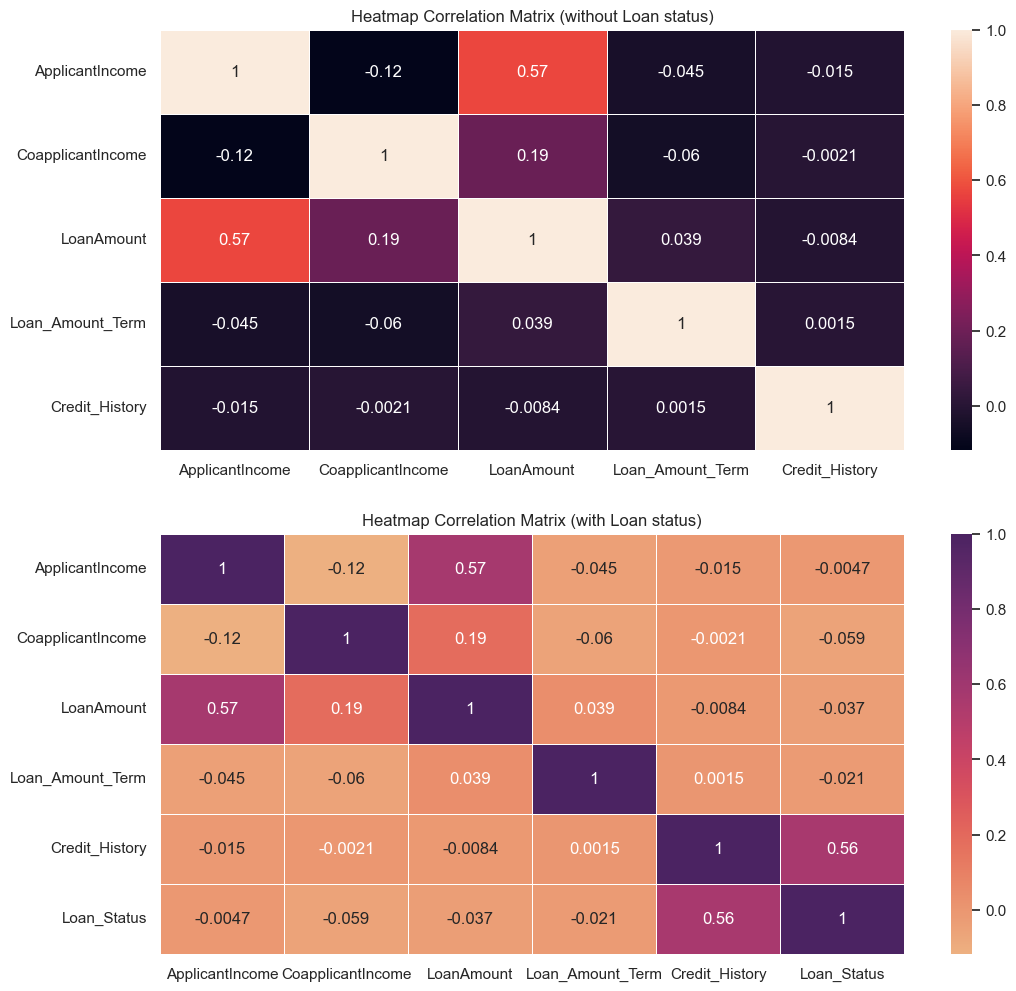

In [301]:
data_correlation = df_train.select_dtypes(include=['int64', 'float64'])

# Correlation between only the predictors variables
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
sns.heatmap(data_correlation.corr(), annot=True, linewidths=0.5)
plt.title('Heatmap Correlation Matrix (without Loan status)')

# Same correlation but by adding the target variable (converted as integer)
data_correlation['Loan_Status'] = df_train['Loan_Status'].replace({'Y': 1, 'N': 0})
data_correlation['Loan_Status'] = data_correlation['Loan_Status'].infer_objects(copy=False)  # Retain old behavior
plt.subplot(2, 1, 2)
sns.heatmap(data_correlation.corr(), annot=True, linewidths=0.5, cmap='flare')
plt.title('Heatmap Correlation Matrix (with Loan status)')

plt.show()

From the correlation matrix we can analyse the following specificities:
- we can see a certain correlation between the **applicant income** and the **loan amount**
- the **coapplicant income** have a weak positive correlation with the **loan amount** (*0.19*), this influence is limited
- if we integrate the target variable, we can see a strong correlation between the ***loan status*** and the **credit history**
- the others variable don't have any significant correlation between them

## Data relationship

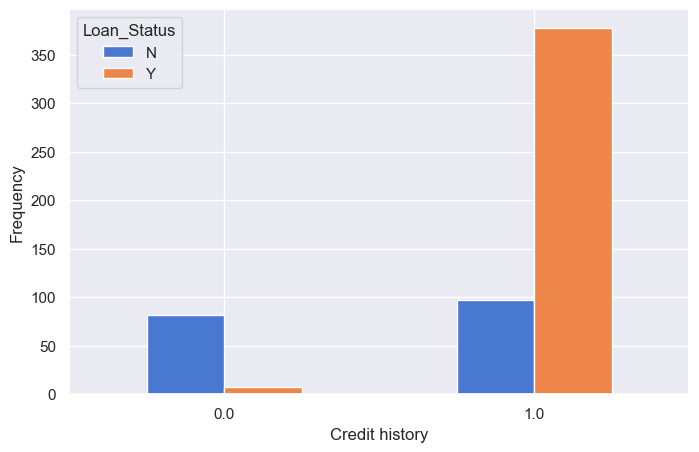

In [302]:
sns.set_theme(palette="muted")

# Credit history
pd.crosstab(df_train['Credit_History'], df_train['Loan_Status']).plot(kind='bar', figsize=(8,5))
plt.xlabel('Credit history')
plt.ylabel('Frequency')

plt.xticks(rotation=0)
plt.show()

According to the relationship between the **credit history** and the **loan status**, we can notice:
- a majority of people with a credit are eligible to a new loan
- among the group who have no actual credit just a few can have a loan and a majority cannot

***In conclusion, having a credit history increase the probability to have his loan accepted***

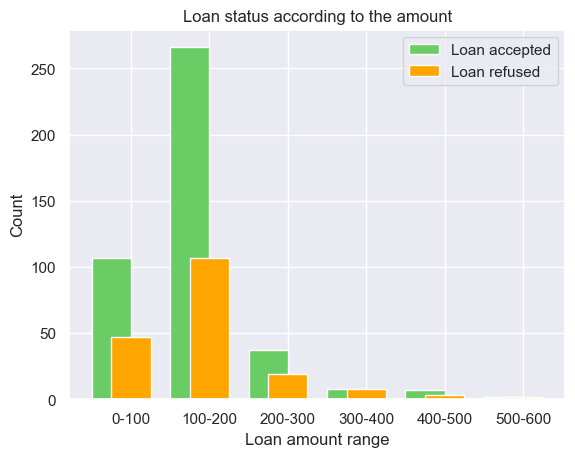

In [324]:
loanAmount_range = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500), (500, 600)]
accepted, notaccepted, amount_label = [], [], []

for amount in loanAmount_range:
    n_loan = df_train['Loan_Status'].loc[df_train['LoanAmount'].between(amount[0], amount[1])].value_counts(dropna=True)
    accepted.append(n_loan['Y'])
    notaccepted.append(n_loan['N'])
    
    label = f"{amount[0]}-{amount[1]}"
    amount_label.append(label)

fig, ax = plt.subplots()
ax.bar(np.arange(len(amount_label)), accepted, color='g', width=0.5, label='Loan accepted')
ax.bar(np.arange(len(amount_label)) + 0.25, notaccepted, color='orange', width=0.5, label='Loan refused')

ax.set_xticks(np.arange(len(amount_label)) + 0.25)
ax.set_xticklabels(amount_label)

ax.set_xlabel('Loan amount range')
ax.set_ylabel('Count')
plt.title('Loan status according to the amount')

ax.legend()
plt.show()

Idées:
 - le Applicant income en fonction du Loan status
 - Applicant income en fonction du Gender
 - Loan status en fonction du Gender
 - Loan status en fonction du Married
 - Loan status en fonction de Education
 - Married en fonction du Gender
 - Property area en fonction du loan status

## **Data cleaning**

### Remove useless variable

In [ ]:
# Remove useless 'Load_ID' column
df_train = df_train.drop('Loan_ID', axis=1)

### Fill missing values

In [ ]:
def fill_variables(dataset):
    # Get numerical and categorical datas
    df_nb = dataset.select_dtypes(include=['int64', 'float64'])
    df_ob = dataset.select_dtypes(include=['object'])

    # Fill NaN numerical values with the mean one
    df_nb = df_nb.fillna(df_nb.mean())

    for column in df_ob.columns:  
        # Fill NaN categorical value with the most repetitive one
        if(df_ob[column].isnull().sum() > 0):
            mode_value = df_ob[column].mode()[0]
            df_ob[column] = df_ob[column].fillna(mode_value)
        
    # Concat numerical and categorical sub dataset
    df_final = pd.concat([df_nb, df_ob], axis=1)
    return df_final


In [ ]:
df_train = fill_variables(df_train)
df_test = fill_variables(df_test)

df_train.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,5849,0.0,146.412162,360.0,1.0,Male,No,0,Graduate,No,Urban,Y
1,4583,1508.0,128.000000,360.0,1.0,Male,Yes,1,Graduate,No,Rural,N
2,3000,0.0,66.000000,360.0,1.0,Male,Yes,0,Graduate,Yes,Urban,Y
3,2583,2358.0,120.000000,360.0,1.0,Male,Yes,0,Not Graduate,No,Urban,Y
4,6000,0.0,141.000000,360.0,1.0,Male,No,0,Graduate,No,Urban,Y


## Normalisation and variables management

In [ ]:
def adapt_variables(dataset):
    # Get numerical and categorical datas
    df_nb = dataset.select_dtypes(include=['int64', 'float64'])
    df_ob = dataset.select_dtypes(include=['object'])


    # Adapt Incomes variables in one column
    df_nb['Total_Income'] = df_nb['ApplicantIncome'] + df_nb['CoapplicantIncome']
    df_nb = df_nb.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], axis=1)

    # Normalize numerical values
    # Depending of the symetrical or asymetrical distribution of the numericals values
    for column in df_nb.columns:
        # Don't normalize Credit History, it's a boolean variable
        skewness = df_nb[column].skew()
        
        if ((skewness > 0.5) or (skewness < -0.5)):
            # Create new log variable and delete original one
            new_column = column + "_Log"
            df_nb[new_column] = np.log(df_nb[column] + 1)
            df_nb = df_nb.drop(column, axis=1)
        else:
            print('No Asymetrical distribution for {column}')

    encoder = LabelEncoder()
    for column in df_ob.columns:
        # Encode categorical values
        df_ob[column] = encoder.fit_transform(df_ob[column].astype(str))

    # Replace values from 'Loan_Status' by 0 or 1
    if 'Loan_Status' in df_ob.columns:
        df_ob['Loan_Status'] = df_ob['Loan_Status'].replace({'Y': 1, 'N': 0})
        df_ob['Loan_Status'] = df_ob['Loan_Status'].infer_objects(copy=False)  # Retain old behavior

    # For Property_Urban --> Rural: 0, Semiurban: 1, Urban: 2 
        
    # Concat numerical and categorical sub dataset
    df_final = pd.concat([df_nb, df_ob], axis=1)
    return df_final

In [ ]:
df_train_final = adapt_variables(df_train)
df_test_final = adapt_variables(df_test)

df_train_final.head()

,LoanAmount_Log,Loan_Amount_Term_Log,Credit_History_Log,Total_Income_Log,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,4.993232,5.888878,0.693147,8.674197,1,0,0,0,0,2,1
1,4.859812,5.888878,0.693147,8.714732,1,1,1,0,0,0,0
2,4.204693,5.888878,0.693147,8.006701,1,1,0,0,1,2,1
3,4.795791,5.888878,0.693147,8.505525,1,1,0,1,0,2,1
4,4.955827,5.888878,0.693147,8.699681,1,0,0,0,0,2,1
